# Deep Learning image classification based on a Convolutional Neural Network


### Import all the necessary libraries


In [127]:
import PIL
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow.keras import layers, models
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight


### Define function to display images with labels in a 5x6 grid


In [133]:
def showImages(images, labels, offset=0):
    class_names = ["Caucasian", "African", "Asian", "Indian"]

    plt.figure(figsize=(10, 10))
    for i in range(30):
        plt.subplot(5, 6, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i + offset], cmap="gray")
        plt.xlabel(class_names[int(np.argmax(labels[i + offset]))])
    plt.show()


## Training area 🏋️

### Import train data


In [92]:
# train data
X_TRAIN = np.load("Xtrain_Classification_Part2.npy")
Y_TRAIN = np.load("Ytrain_Classification_Part2.npy")

print(f"X_TRAIN: {X_TRAIN.shape}")
print(f"Y_TRAIN: {Y_TRAIN.shape}")


X_TRAIN: (7366, 2500)
Y_TRAIN: (7366,)


### Split data into train and validation sets


In [93]:
# Use 20% of the data as validation
train_set, validation_set, train_labels, validation_labels = train_test_split(
    X_TRAIN, Y_TRAIN, test_size=0.2, random_state=69
)


### Oversample to balance the data


In [94]:
# ros = RandomOverSampler(random_state=0, sampling_strategy='minority')
# X_resampled, y_resampled = ros.fit_resample(train_set, train_labels)

# train_set = X_resampled

# train_labels = y_resampled


In [95]:
# check amount of data per classin train and validation sets
print(f"Train data has:")
print(f"\t • {(train_labels == 0).sum()} caucasians")
print(f"\t • {(train_labels == 1).sum()} africans")
print(f"\t • {(train_labels == 2).sum()} asians")
print(f"\t • {(train_labels == 3).sum()} indians")

print()

print(f"Validation data has:")
print(f"\t • {(validation_labels == 0).sum()} caucasians")
print(f"\t • {(validation_labels == 1).sum()} africans")
print(f"\t • {(validation_labels == 2).sum()} asians")
print(f"\t • {(validation_labels == 3).sum()} indians")


Train data has:
	 • 3592 caucasians
	 • 278 africans
	 • 1058 asians
	 • 964 indians

Validation data has:
	 • 886 caucasians
	 • 63 africans
	 • 280 asians
	 • 245 indians


### Reshape images to a 50x50 square


In [96]:
train_set = train_set.reshape(train_set.shape[0], 50, 50, 1) / 255
validation_set = validation_set.reshape(validation_set.shape[0], 50, 50, 1) / 255

print(f"train_set: {train_set.shape}")
print(f"validation_set: {validation_set.shape}")
print(f"Joint length: {train_set.shape[0] + validation_set.shape[0]}")


train_set: (5892, 50, 50, 1)
validation_set: (1474, 50, 50, 1)
Joint length: 7366


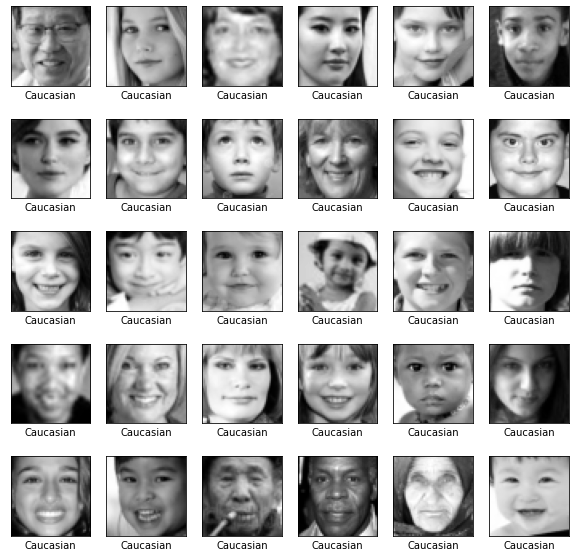

In [134]:
showImages(train_set, train_labels, offset=0)


### Calculate the wheigth of each class


In [98]:
# train will give more importance to classes with a bigger weight
weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)

weights_dict = {0: weights[0], 1: weights[1], 2: weights[2], 3: weights[3]}
print(f"Class weights: {weights_dict}")


Class weights: {0: 0.41007795100222716, 1: 5.298561151079137, 2: 1.392249527410208, 3: 1.5280082987551866}


### Create FaiscaMcQueen ⚡


In [99]:
FaiscaMcQueen = models.Sequential(name="RelampagoMarquinhos")

# doesn't make data augmentation, only flips random images
FaiscaMcQueen.add(layers.RandomFlip(mode="horizontal", input_shape=(50, 50, 1)))

FaiscaMcQueen.add(layers.Conv2D(32, (3, 3), activation="linear"))
FaiscaMcQueen.add(layers.LeakyReLU())
FaiscaMcQueen.add(layers.MaxPooling2D((2, 2)))
FaiscaMcQueen.add(layers.Dropout(0.3))


FaiscaMcQueen.add(layers.Conv2D(64, (3, 3), activation="linear"))
FaiscaMcQueen.add(layers.LeakyReLU())
FaiscaMcQueen.add(layers.MaxPooling2D((2, 2)))
FaiscaMcQueen.add(layers.Dropout(0.3))

FaiscaMcQueen.add(layers.Flatten())
FaiscaMcQueen.add(layers.Dense(64, activation="relu"))
FaiscaMcQueen.add(layers.Dense(32, activation="relu"))
FaiscaMcQueen.add(layers.Dense(4, activation="softmax"))

FaiscaMcQueen.summary()


Model: "RelampagoMarquinhos"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_3 (RandomFlip)   (None, 50, 50, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 22, 22, 64)

### Compile and train the model


In [100]:
# We are using SparseCategoricalCrossentropy because our classes are integers between 0 and 3
# We are not using one hot encoding
FaiscaMcQueen.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

history = FaiscaMcQueen.fit(
    train_set,
    train_labels,
    epochs=50,
    class_weight=weights_dict,
    validation_data=(validation_set, validation_labels),
    verbose=False,
    callbacks=[early_stopping_callback],
)

print(f"Trained during {len(history.history['loss'])} epochs")


Trained during 16 epochs


### Plot train and validation accuracy and loss over train epochs

Validation: acc is 82.29308128356934% and loss is 0.48860010504722595


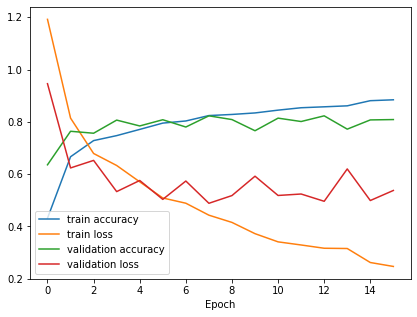

In [110]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_accuracy"], label="validation accuracy")
plt.plot(history.history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.legend(loc="lower left")

validation_loss, validation_acc = FaiscaMcQueen.evaluate(validation_set, validation_labels, verbose=False)

print(f"Validation: acc is {validation_acc*100}% and loss is {validation_loss}")

### Compute balance accuracy

In [112]:
from sklearn.metrics import balanced_accuracy_score

y_hat = FaiscaMcQueen.predict(validation_set)

y_hat = np.array([np.argmax(label) for label in y_hat])

print(f"Validation balanced acc is: {balanced_accuracy_score(validation_labels, y_hat)*100}%")


Validation balanced acc is: 81.21932633098386%


## Testing area 🏆

### Import and reshape test data


In [113]:
# test data
X_TEST = np.load("Xtest_Classification_Part2.npy")

X_TEST = X_TEST.reshape(X_TEST.shape[0], 50, 50, 1) / 255

print(f"X_TEST shape: {X_TEST.shape}")


X_TEST shape: (1290, 50, 50, 1)


### Predict labels and save them

In [120]:
y_pred = FaiscaMcQueen.predict(X_TEST)

y_pred = np.array([np.argmax(label) for label in y_pred])

print(f"y_pred shape: {y_pred.shape}")
print(f"y_pred partial: {y_pred[10:40]}")

with open("predicor.npy", "wb") as f:
    np.save(f, y_pred)


y_pred shape: (1290,)
y_pred partial: [0 0 0 0 0 3 0 3 0 0 2 2 0 0 3 1 2 0 3 2 0 0 3 0 0 1 3 0 2 2]


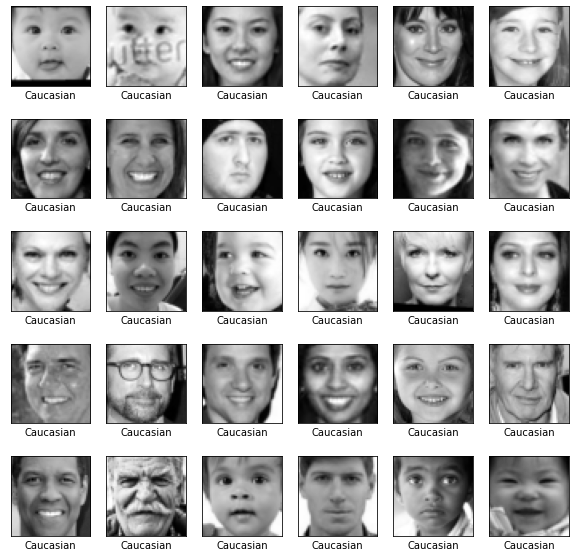

In [121]:
# offset 756 mostra o steve carell e o han solo
showImages(X_TEST, y_pred, offset=756)

### Test how FaiscaMcQueen ⚡ classifies images from outside the given scope


African


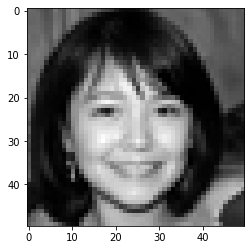

In [132]:
# put here a random image to see what happens
image = PIL.Image.open("image2.jpg").convert("L").resize((50, 50))

image_array = np.asarray(image)

image_array = image_array.reshape(1, 50, 50, 1) / 255

predicted = FaiscaMcQueen.predict(image_array)

plt.imshow(image_array[0], cmap="gray")

class_names = ["Caucasian", "African", "Asian", "Indian"]
print(class_names[int(np.argmax(predicted))])
